# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion2 import * 
from MCSAmericanOptionPricing import *
import math

seed = 24 #1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:24


### Variable settings

In [2]:
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 200 #60

In [3]:
save_model_freq = 10000 #5000
Normalization = False #True #False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 128 #64 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 10000 #3000 #1000
learning_rate = 0.0001 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50
input_size = history_t + 2
is_training = True

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 106.01567271416633, max value of stock: 197.0211505221744


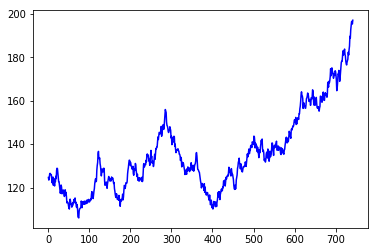

In [6]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

### Implementing the network itself

In [7]:
class Qnetwork():
    def __init__(self,myScope):
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the LSTM is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        initializer = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(initializer([h_size//2,2]))
        self.VW = tf.Variable(initializer([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        if dueling_type == 'avg':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'max':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_max(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'naive':
            self.Qout = self.Value + self.Advantage
        
        self.predict = tf.argmax(self.Qout,1)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        # calculate the temporal difference error.
        if huber_loss == True:
            self.td_error = tf.losses.huber_loss(self.targetQ, self.Q, reduction=tf.losses.Reduction.NONE)
        else:
            self.td_error = tf.square(self.targetQ - self.Q)
            
        #For test purpose
        self.Q_sell_error = tf.square(self.Qout[:,1] - self.scalarInput[:,0])
        self.Q_sell_loss = tf.cast(tf.reduce_sum(self.Q_sell_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)

        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [9]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #How often to perform a training step.
update_online_freq = 5
update_target_freq = 300
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs
pre_train_episodes = 1000
annealing_episodes = int(num_episodes * 0.3)
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
trained_model_name = os.path.join(path, 'RL_10000rep_200seeds_0001_128batch_1000pre_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-dueling_type' + str(dueling_type)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))

final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
print('#gamma: ' + str(gamma))

#num_episodes: 678000
#trace_length: 38
#gamma: 0.9998016069840849
C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final


In [10]:
e=0

### Testing the network on train set again

In [11]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 183.89506559405115, max value of stock: 225.71786417155334


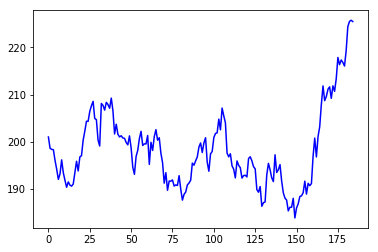

In [12]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [13]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

totalAveragerewardPerEpisode = np.mean(rList)
maxPossibleAveragerewardPerEpisode = np.mean(maxPossiblerList)
CI90 = env.getConfidenceInterval(rList)
CI95 = env.getConfidenceInterval95(rList)
sEntropy = env.getEntropy(sTimeList)
percentageStockReturnNormalized = np.mean(percentage_rList)
percentageStockReturnReal = np.mean(real_percentage_rList)
percentageOptionReturnNormalized = np.mean(option_percentage_rList)
percentageOptionReturnReal = np.mean(option_real_percentage_rList)
maxPossibleAverageStockPercentageReturnPerEpisode = np.mean(maxPossibleP_returnList)
maxPossibleAverageRealStockPercentageReturnPerEpisode = np.mean(maxPossibleR_P_returnList)
maxPossibleAverageOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionP_returnList)
maxPossibleAverageRealOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionR_P_returnList)
CIPercentageReturnNormalized90 = env.getConfidenceInterval(percentage_rList)
CIPercentageReturnNormalized95 = env.getConfidenceInterval95(percentage_rList)
CIPercentageReturnReal90 = env.getConfidenceInterval(real_percentage_rList)
CIPercentageReturnReal95 = env.getConfidenceInterval95(real_percentage_rList)
CIPercentageOptionReturnNormalized90 = env.getConfidenceInterval(option_percentage_rList)
CIPercentageOptionReturnNormalized95 = env.getConfidenceInterval95(option_percentage_rList)
CIPercentageOptionReturnReal90 = env.getConfidenceInterval(option_real_percentage_rList)
CIPercentageOptionReturnReal95 = env.getConfidenceInterval95(option_real_percentage_rList)
print ("#Total average reward per episode: " + str(totalAveragerewardPerEpisode))

print ("#Max possible average reward per episode: " + str(maxPossibleAveragerewardPerEpisode))

print ("#Confidence Interval with prob of 90%: " + str(CI90))

print ("#Confidence Interval with prob of 95%: " + str(CI95))

print ("#Sell time entropy: " + str(sEntropy))

print ("#Percentage of stock returns (Normalized): " + str(percentageStockReturnNormalized))

print ("#Percentage of stock returns (Real values): " + str(percentageStockReturnReal))

print ("#Percentage of option returns (Normalized): " + str(percentageOptionReturnNormalized))

print ("#Percentage of option returns (Real values): " + str(percentageOptionReturnReal))

print ("#Max possible average stock percentage return per episode: " + str(maxPossibleAverageStockPercentageReturnPerEpisode))

print ("#Max possible average real stock percentage return per episode: " + str(maxPossibleAverageRealStockPercentageReturnPerEpisode))

print ("#Max possible average option percentage return per episode: " + str(maxPossibleAverageOptionPercentageReturnPerEpisode))

print ("#Max possible average real option percentage return per episode: " + str(maxPossibleAverageRealOptionPercentageReturnPerEpisode))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(CIPercentageReturnNormalized90))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(CIPercentageReturnNormalized95))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(CIPercentageReturnReal90))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(CIPercentageReturnReal95))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(CIPercentageOptionReturnNormalized90))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(CIPercentageOptionReturnNormalized95))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(CIPercentageOptionReturnReal90))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(CIPercentageOptionReturnReal95))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.02910966524213318	17.65
episode 200: 	0.03143368611852764	17.2

episode 13500: 	0.02853887014088631	19.13
episode 13600: 	0.023559655558491984	18.79
episode 13700: 	0.023968313343348608	17.28
episode 13800: 	0.03288599567625279	22.83
episode 13900: 	0.037811377865358875	22.83
episode 14000: 	0.02817995309633854	18.02
episode 14100: 	0.01733022471714342	15.06
episode 14200: 	0.025649409182977242	16.91
episode 14300: 	0.028942921991348455	18.02
episode 14400: 	0.028093786043014806	18.39
episode 14500: 	0.02648007359364228	18.76
episode 14600: 	0.03426624473485944	20.98
episode 14700: 	0.021510871989860972	16.91
episode 14800: 	0.02828037609725702	16.91
episode 14900: 	0.033278873985282176	20.98
episode 15000: 	0.028604089958149982	19.87
#Average reward per episode 15000: 0.028175465243054632
episode 15100: 	0.023865193006788254	18.02
episode 15200: 	0.03571419326873902	20.98
episode 15300: 	0.028141462328102836	19.87
episode 15400: 	0.025757287706219475	17.65
episode 15500: 	0.03027296246867973	19.13
episode 15600: 	0.027703571038167552	17.65
episode

episode 32300: 	0.029480400525272434	18.39
episode 32400: 	0.020575717427538064	16.54
episode 32500: 	0.03203210623258386	20.61
episode 32600: 	0.02222597887679001	14.69
episode 32700: 	0.025278128490729253	17.28
episode 32800: 	0.025226960385976393	16.91
episode 32900: 	0.03057836538765303	22.46
episode 33000: 	0.02889609278623367	18.39
episode 33100: 	0.029860321396679806	20.24
episode 33200: 	0.020654896050387714	17.28
episode 33300: 	0.03168206914540771	21.72
episode 33400: 	0.02230153408570357	16.17
episode 33500: 	0.022440595781594942	18.39
episode 33600: 	0.031339928338531824	19.5
episode 33700: 	0.030125214402056514	17.28
episode 33800: 	0.023059876036628534	16.91
episode 33900: 	0.02967201124219895	19.13
episode 34000: 	0.026546746350260747	17.28
episode 34100: 	0.021112026316495322	15.43
episode 34200: 	0.02651345507189427	18.76
episode 34300: 	0.031470361510676725	18.39
episode 34400: 	0.03226883083893721	20.26
episode 34500: 	0.032973545062724686	18.39
episode 34600: 	0.023

episode 51200: 	0.03230517668945855	20.24
episode 51300: 	0.038570133099701594	20.24
episode 51400: 	0.02671769862866283	19.5
episode 51500: 	0.03244354609129105	22.09
episode 51600: 	0.027842945965953946	18.76
episode 51700: 	0.026204750285196834	16.91
episode 51800: 	0.03178458409327118	20.24
episode 51900: 	0.02567487275521802	18.76
episode 52000: 	0.026203510536003293	17.28
episode 52100: 	0.026581691073178506	19.13
episode 52200: 	0.023497169133853215	18.76
episode 52300: 	0.028574774351411487	17.65
episode 52400: 	0.028052606826970236	18.02
episode 52500: 	0.03000926952596748	19.87
episode 52600: 	0.026933149494151588	17.65
episode 52700: 	0.02519046228449914	17.28
episode 52800: 	0.02995823317166605	20.24
episode 52900: 	0.02852417663178293	17.65
episode 53000: 	0.025177549811872754	18.4
episode 53100: 	0.03109987758587424	20.98
episode 53200: 	0.02032721914444097	15.8
episode 53300: 	0.031229760262618547	19.5
episode 53400: 	0.03305724991465194	19.5
episode 53500: 	0.0383903937

episode 70100: 	0.02419690785603618	18.03
episode 70200: 	0.02210102832338625	18.02
episode 70300: 	0.03024619948475277	20.24
episode 70400: 	0.023530884444299162	18.39
episode 70500: 	0.03454216863201391	22.83
episode 70600: 	0.023793547731861285	20.98
episode 70700: 	0.03546404072404805	23.2
episode 70800: 	0.033268500017107974	20.24
episode 70900: 	0.026924105352521224	17.65
episode 71000: 	0.028967803921508103	18.39
episode 71100: 	0.03557173092707946	21.35
episode 71200: 	0.022050306091559738	16.17
episode 71300: 	0.021875927155535234	17.65
episode 71400: 	0.023622723906426148	16.18
episode 71500: 	0.026306650365744356	18.02
episode 71600: 	0.026011650542495702	19.13
episode 71700: 	0.03470875925715142	20.98
episode 71800: 	0.03195811677112185	18.39
episode 71900: 	0.02835023437432274	16.17
episode 72000: 	0.027081707297429425	18.41
episode 72100: 	0.03749933771862762	22.46
episode 72200: 	0.02734196786434168	18.39
episode 72300: 	0.026889777049388483	17.28
episode 72400: 	0.02072

episode 89100: 	0.03167857063467154	18.76
episode 89200: 	0.028746073933106794	18.76
episode 89300: 	0.025251564843811462	19.13
episode 89400: 	0.02270176540389349	16.54
episode 89500: 	0.03225466431440217	20.61
episode 89600: 	0.024441118397437206	16.91
episode 89700: 	0.02839452085010942	19.5
episode 89800: 	0.02479054654761275	18.02
episode 89900: 	0.028367836339754985	19.5
episode 90000: 	0.025344884987948162	17.65
#Average reward per episode 90000: 0.028276206927416923
episode 90100: 	0.032561457669486316	21.35
episode 90200: 	0.034022541859128855	19.5
episode 90300: 	0.027999365993649862	19.13
episode 90400: 	0.02265847823104596	18.77
episode 90500: 	0.038932914023161985	22.46
episode 90600: 	0.02841222791321655	19.87
episode 90700: 	0.03763213574150561	19.5
episode 90800: 	0.03500101341032753	20.24
episode 90900: 	0.02876055481712615	18.76
episode 91000: 	0.020151713448823654	16.92
episode 91100: 	0.036655252616481906	20.61
episode 91200: 	0.031775356365643576	19.87
episode 9130

episode 107700: 	0.026196054928668732	17.65
episode 107800: 	0.024687243522082583	17.28
episode 107900: 	0.03102764513309975	20.24
episode 108000: 	0.025316295396113422	19.5
episode 108100: 	0.029442632636406337	19.13
episode 108200: 	0.030082773228011207	17.65
episode 108300: 	0.0281261030623335	19.51
episode 108400: 	0.025557575408351685	19.13
episode 108500: 	0.038629370643738566	24.68
episode 108600: 	0.029120580929798384	18.76
episode 108700: 	0.02563466415909418	20.61
episode 108800: 	0.03275689023486292	19.87
episode 108900: 	0.024451606996451783	19.5
episode 109000: 	0.024642838286065	18.02
episode 109100: 	0.031943406843186126	21.72
episode 109200: 	0.02671777335320273	16.91
episode 109300: 	0.027689353666065748	17.65
episode 109400: 	0.03055537865548309	19.5
episode 109500: 	0.02592780014712328	18.76
episode 109600: 	0.027841174145340587	18.39
episode 109700: 	0.030984966137345204	22.09
episode 109800: 	0.028226293981413263	19.5
episode 109900: 	0.025877351841548685	16.91
epi

episode 126100: 	0.03927680168327461	20.98
episode 126200: 	0.025975801512246974	17.28
episode 126300: 	0.027969226818530885	18.76
episode 126400: 	0.02334863533295306	16.54
episode 126500: 	0.034575841592134234	16.91
episode 126600: 	0.02859197648588009	20.98
episode 126700: 	0.024016195770181926	15.8
episode 126800: 	0.026656153553605528	18.02
episode 126900: 	0.039349720978107024	22.46
episode 127000: 	0.02923321336152612	17.29
episode 127100: 	0.034442518486015955	20.24
episode 127200: 	0.025755467879251842	16.91
episode 127300: 	0.032548691009288214	22.09
episode 127400: 	0.031613820196847546	20.98
episode 127500: 	0.028889110931255284	19.13
episode 127600: 	0.023522722053088314	16.17
episode 127700: 	0.02905444375316381	20.61
episode 127800: 	0.02598396013121845	19.13
episode 127900: 	0.036716588251727154	21.35
episode 128000: 	0.040276902561734246	23.57
episode 128100: 	0.027430494523226198	17.28
episode 128200: 	0.03258033708278172	20.24
episode 128300: 	0.02170714451978312	16.

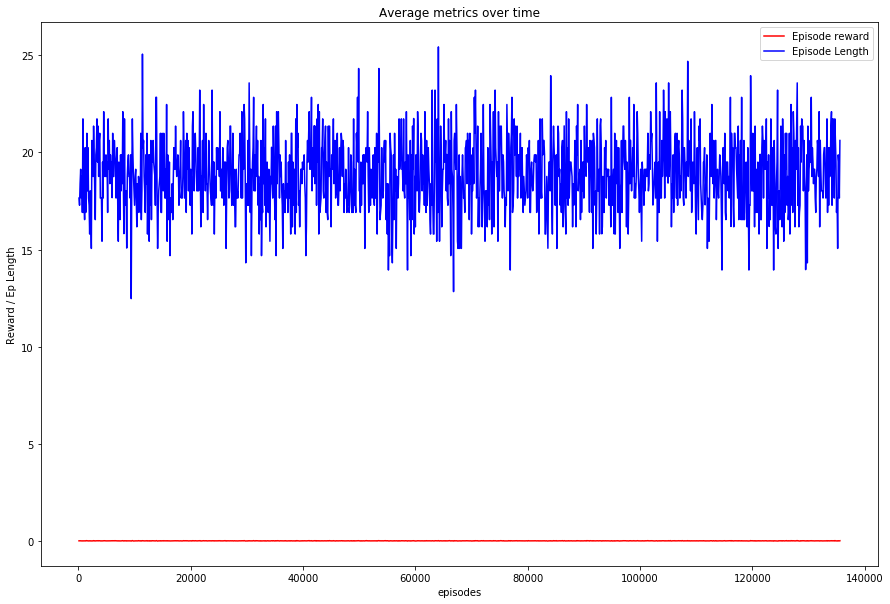

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

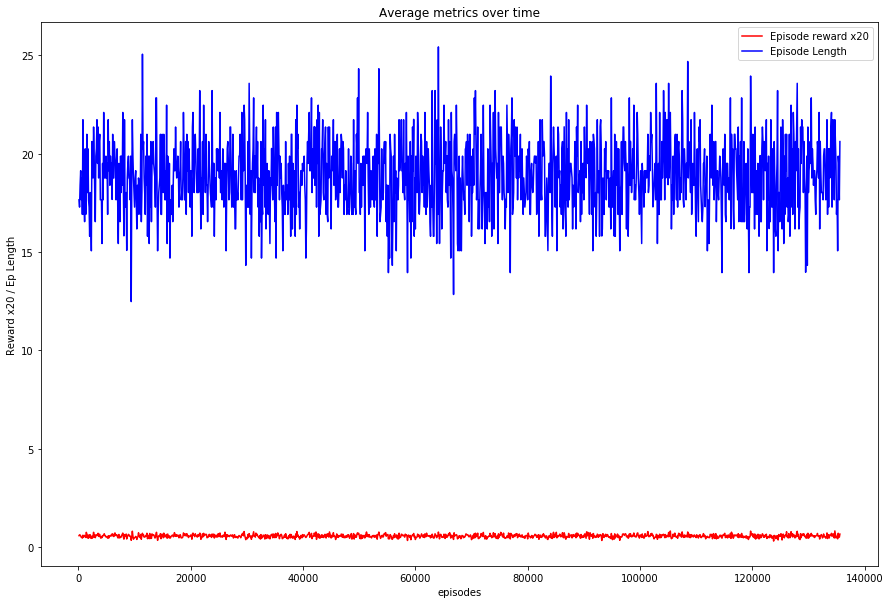

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

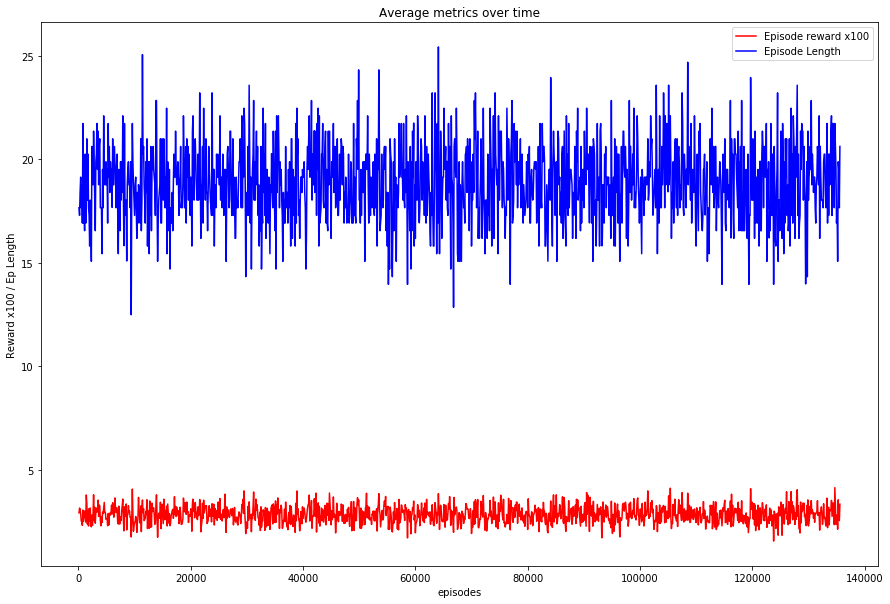

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

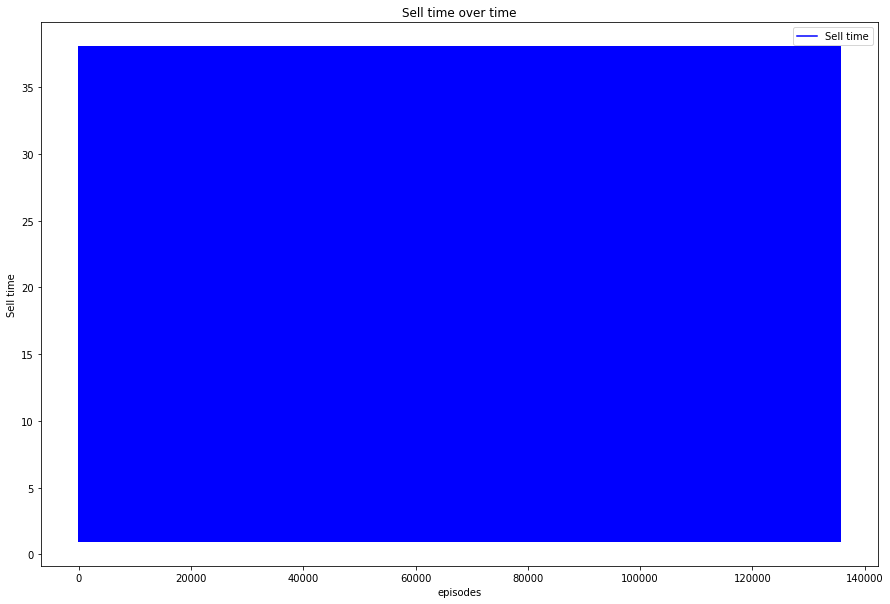

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Testing the network

In [19]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 183.89506559405115, max value of stock: 225.71786417155334


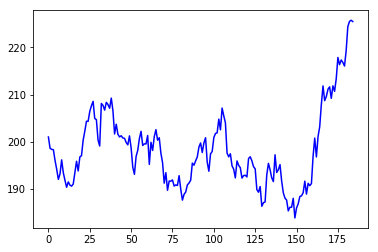

In [20]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [21]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

totalAveragerewardPerEpisode = np.mean(rList)
maxPossibleAveragerewardPerEpisode = np.mean(maxPossiblerList)
CI90 = env.getConfidenceInterval(rList)
CI95 = env.getConfidenceInterval95(rList)
sEntropy = env.getEntropy(sTimeList)
percentageStockReturnNormalized = np.mean(percentage_rList)
percentageStockReturnReal = np.mean(real_percentage_rList)
percentageOptionReturnNormalized = np.mean(option_percentage_rList)
percentageOptionReturnReal = np.mean(option_real_percentage_rList)
maxPossibleAverageStockPercentageReturnPerEpisode = np.mean(maxPossibleP_returnList)
maxPossibleAverageRealStockPercentageReturnPerEpisode = np.mean(maxPossibleR_P_returnList)
maxPossibleAverageOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionP_returnList)
maxPossibleAverageRealOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionR_P_returnList)
CIPercentageReturnNormalized90 = env.getConfidenceInterval(percentage_rList)
CIPercentageReturnNormalized95 = env.getConfidenceInterval95(percentage_rList)
CIPercentageReturnReal90 = env.getConfidenceInterval(real_percentage_rList)
CIPercentageReturnReal95 = env.getConfidenceInterval95(real_percentage_rList)
CIPercentageOptionReturnNormalized90 = env.getConfidenceInterval(option_percentage_rList)
CIPercentageOptionReturnNormalized95 = env.getConfidenceInterval95(option_percentage_rList)
CIPercentageOptionReturnReal90 = env.getConfidenceInterval(option_real_percentage_rList)
CIPercentageOptionReturnReal95 = env.getConfidenceInterval95(option_real_percentage_rList)
print ("#Total average reward per episode: " + str(totalAveragerewardPerEpisode))

print ("#Max possible average reward per episode: " + str(maxPossibleAveragerewardPerEpisode))

print ("#Confidence Interval with prob of 90%: " + str(CI90))

print ("#Confidence Interval with prob of 95%: " + str(CI95))

print ("#Sell time entropy: " + str(sEntropy))

print ("#Percentage of stock returns (Normalized): " + str(percentageStockReturnNormalized))

print ("#Percentage of stock returns (Real values): " + str(percentageStockReturnReal))

print ("#Percentage of option returns (Normalized): " + str(percentageOptionReturnNormalized))

print ("#Percentage of option returns (Real values): " + str(percentageOptionReturnReal))

print ("#Max possible average stock percentage return per episode: " + str(maxPossibleAverageStockPercentageReturnPerEpisode))

print ("#Max possible average real stock percentage return per episode: " + str(maxPossibleAverageRealStockPercentageReturnPerEpisode))

print ("#Max possible average option percentage return per episode: " + str(maxPossibleAverageOptionPercentageReturnPerEpisode))

print ("#Max possible average real option percentage return per episode: " + str(maxPossibleAverageRealOptionPercentageReturnPerEpisode))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(CIPercentageReturnNormalized90))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(CIPercentageReturnNormalized95))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(CIPercentageReturnReal90))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(CIPercentageReturnReal95))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(CIPercentageOptionReturnNormalized90))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(CIPercentageOptionReturnNormalized95))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(CIPercentageOptionReturnReal90))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(CIPercentageOptionReturnReal95))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.02521382761449973	15.8
episode 200: 	0.02761500867984468	18.39
episode 300: 	0.03012601566134313	17.65
episode 400: 	0.02954872506976025	19.13
episode 500: 	0.025237568806182064	20.61
episode 600: 	0.030201185772523335	19.5
episode 700: 	0.033329131176980935	21.35
episode 800: 	0.02335438133365987	16.91
episode 900: 	0.029633219734471274	19.87
episode 1000: 	0.025718307018572757	19.5
episode 1100: 	0.02508306445188213	16.91
episode 1200: 	0.028719949166458	18.39
episode 1300: 	0.022989265219642518	16.54
episode 1400: 	0.022025847544174165	15.43
episode 1500: 	0.028784405140918054	19.5
episode 1600: 	0.02833972657850382	18.76
episode 1700: 	0.029027715704564302	18.76
episode 1800: 	0.02823745

episode 18600: 	0.03160301302662546	20.98
episode 18700: 	0.027383548294453917	19.13
episode 18800: 	0.031564923161493605	19.87
episode 18900: 	0.022465326782451337	16.54
episode 19000: 	0.031024246384298067	19.13
episode 19100: 	0.02178639976557407	16.17
episode 19200: 	0.02519210613217644	18.76
episode 19300: 	0.029369287344256492	19.87
episode 19400: 	0.027251235120504244	19.87
episode 19500: 	0.024800719431222903	18.76
episode 19600: 	0.0327121670093931	19.5
episode 19700: 	0.021735153046369304	17.65
episode 19800: 	0.022273002761425346	18.02
episode 19900: 	0.026347848723189307	17.65
episode 20000: 	0.030840485914111454	15.8
#Average reward per episode 20000: 0.02722863995299254
episode 20100: 	0.022106496863655532	18.39
episode 20200: 	0.02761980964332647	17.65
episode 20300: 	0.03093861041875172	19.87
episode 20400: 	0.03187852828738213	19.13
episode 20500: 	0.026128586882233084	18.76
episode 20600: 	0.026543391004688912	15.43
episode 20700: 	0.023723113531470205	17.28
episode 2

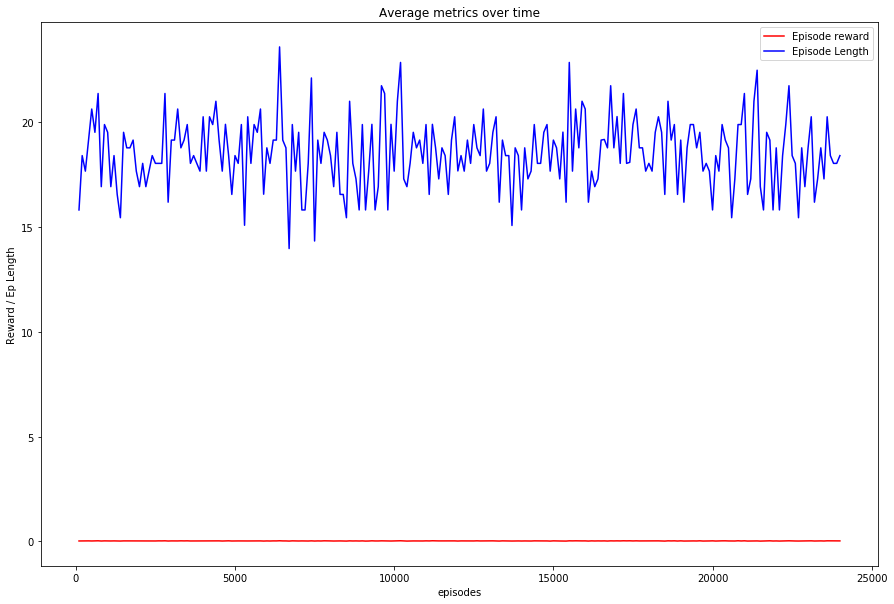

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

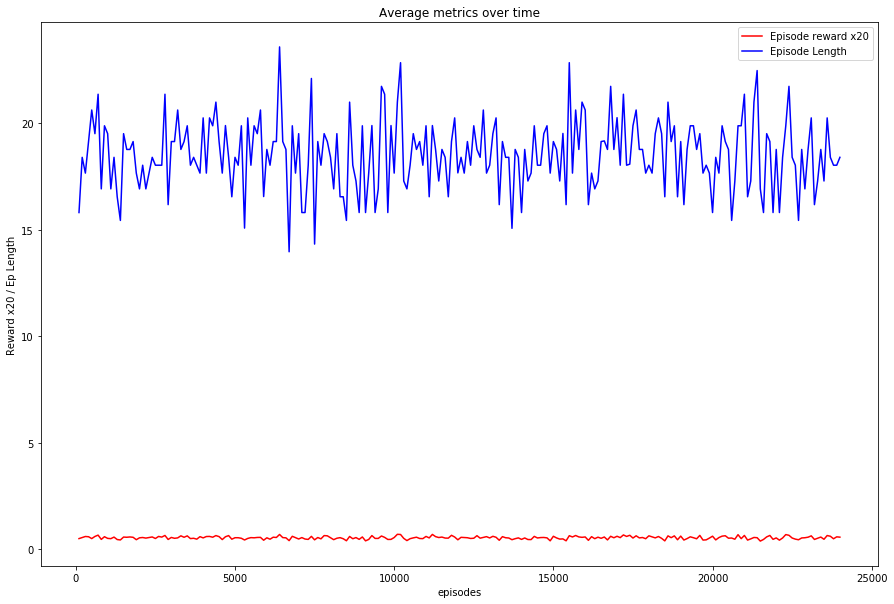

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

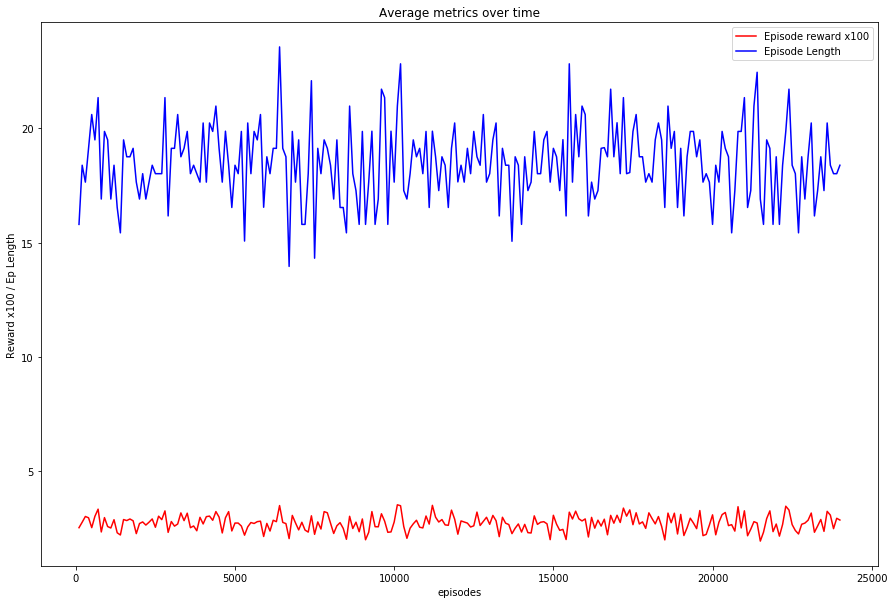

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

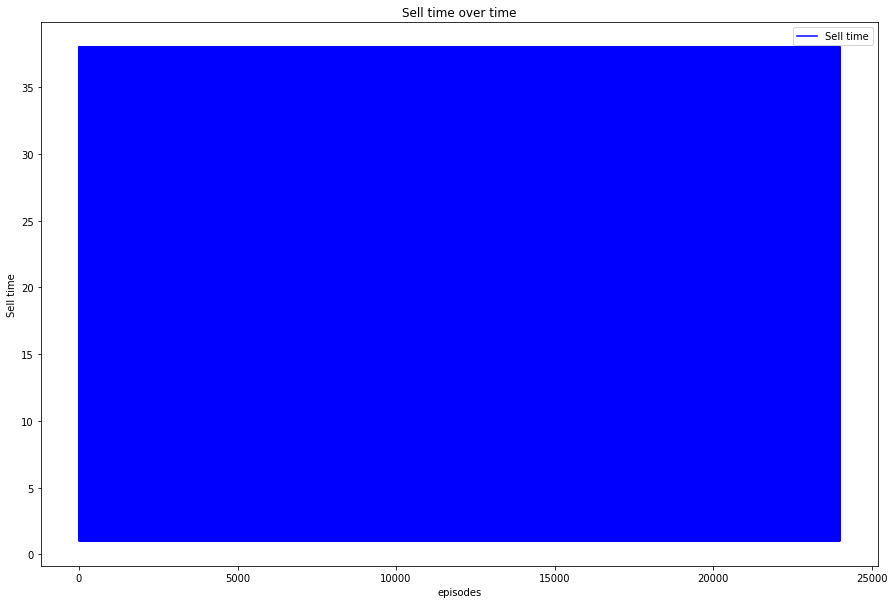

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

min value of data: 108.87524389134241, max value of data: 188.56082216931188
train_size: 743
test_size: 185
min value of data: 128.61971170009193, max value of data: 274.35215354173266
train_size: 743
test_size: 185
min value of data: 62.03602991343512, max value of data: 95.64161820654094
train_size: 743
test_size: 185
min value of data: 148.92583383758014, max value of data: 296.08994342434
train_size: 743
test_size: 185
min value of data: 50.05087009447692, max value of data: 81.81118484899123
train_size: 743
test_size: 185
min value of data: 141.6679007915422, max value of data: 237.497617689898
train_size: 743
test_size: 185
min value of data: 143.1110091184379, max value of data: 258.42341925020963
train_size: 743
test_size: 185
min value of data: 81.51807513764079, max value of data: 143.1274713426479
train_size: 743
test_size: 185
min value of data: 51.4101233454379, max value of data: 89.80889577657041
train_size: 743
test_size: 185
min value of data: 121.58161811184277, max v

min value of data: 98.08499759941712, max value of data: 195.0808989503367
train_size: 743
test_size: 185
min value of data: 154.77386934673368, max value of data: 330.82191983531413
train_size: 743
test_size: 185
min value of data: 108.35732112513853, max value of data: 236.04489283834158
train_size: 743
test_size: 185
min value of data: 150.36804690074973, max value of data: 281.1707183525495
train_size: 743
test_size: 185
min value of data: 101.19661302831037, max value of data: 173.25167545580285
train_size: 743
test_size: 185
min value of data: 86.58251259280541, max value of data: 149.8048725739641
train_size: 743
test_size: 185
min value of data: 119.44058423627827, max value of data: 191.47123856045187
train_size: 743
test_size: 185
min value of data: 101.64937796689765, max value of data: 194.48453775493002
train_size: 743
test_size: 185
min value of data: 122.32516838103388, max value of data: 230.0167970389437
train_size: 743
test_size: 185
min value of data: 88.551394277080

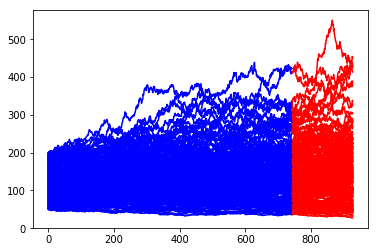

In [28]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 176.43635326910925, max value of stock: 227.42584621096825


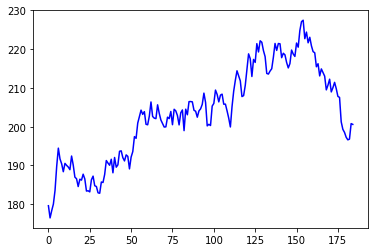

In [29]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [30]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.028317417584841565	21.72
episode 200: 	0.024635148326489376	15.06
episode 300: 	0.029016697432359986	20.24
episode 400: 	0.02012668991011179	14.69
episode 500: 	0.02483595883916455	20.24
episode 600: 	0.03003426373553756	19.13
episode 700: 	0.02455313727494559	19.13
episode 800: 	0.03467394259086229	20.98
episode 900: 	0.026958723632510194	16.91
episode 1000: 	0.029397082616854715	16.91
episode 1100: 	0.02807752891380978	18.02
episode 1200: 	0.022801467890188432	19.13
episode 1300: 	0.02835475881647538	17.28
episode 1400: 	0.025374532932283502	16.54
episode 1500: 	0.03394797238758174	20.24
episode 1600: 	0.038120739287797904	20.98
episode 1700: 	0.03096458023249574	19.5
episode 1800: 	0.0234

episode 18700: 	0.028970656872868577	19.5
episode 18800: 	0.030615036392755503	19.5
episode 18900: 	0.02576758963750933	18.02
episode 19000: 	0.025862348660116746	18.02
episode 19100: 	0.02315601771937161	18.39
episode 19200: 	0.027278803968216962	17.28
episode 19300: 	0.030668333510487315	18.02
episode 19400: 	0.03146709902529885	17.28
episode 19500: 	0.03072706238829671	19.87
episode 19600: 	0.02568328205206229	18.39
episode 19700: 	0.030967214246010632	20.98
episode 19800: 	0.028174106451016704	17.28
episode 19900: 	0.027081328116963482	20.61
episode 20000: 	0.025551296968823616	18.76
#Average reward per episode 20000: 0.028514203634246383
episode 20100: 	0.03367541367512924	19.87
episode 20200: 	0.03197289601012782	21.35
episode 20300: 	0.03571573330715647	22.83
episode 20400: 	0.030343795152822754	18.41
episode 20500: 	0.029763950644747367	20.24
episode 20600: 	0.023102002223254214	14.69
episode 20700: 	0.028626391591256614	20.98
episode 20800: 	0.022907653673263185	14.69
episode 

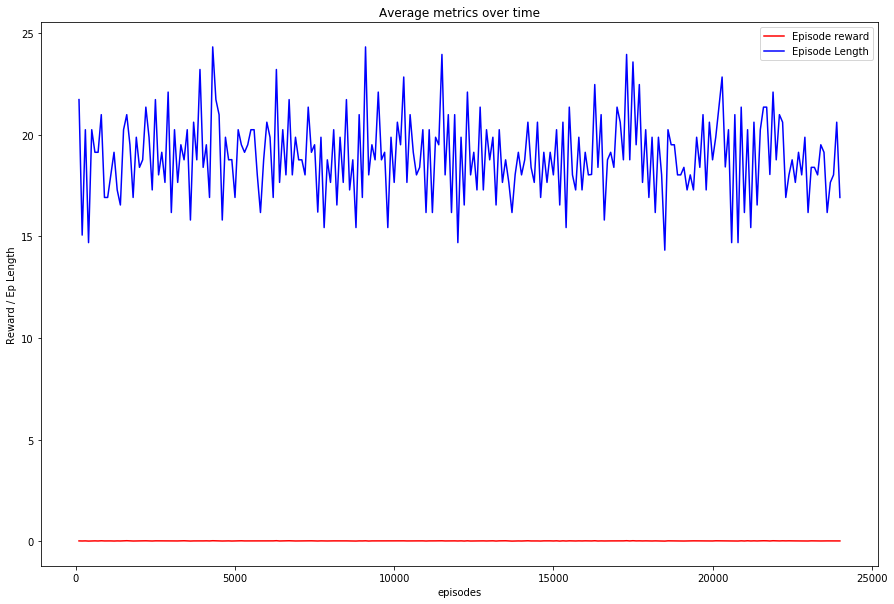

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

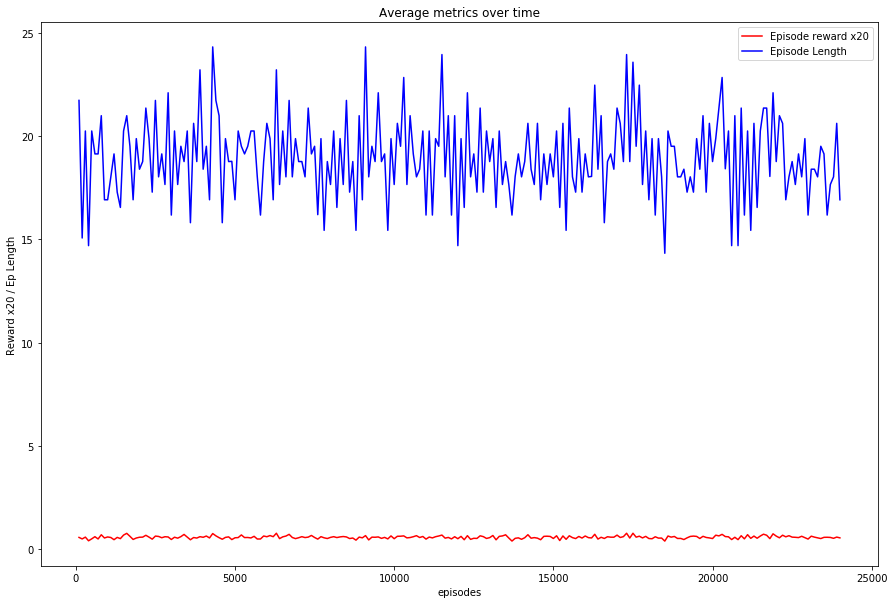

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

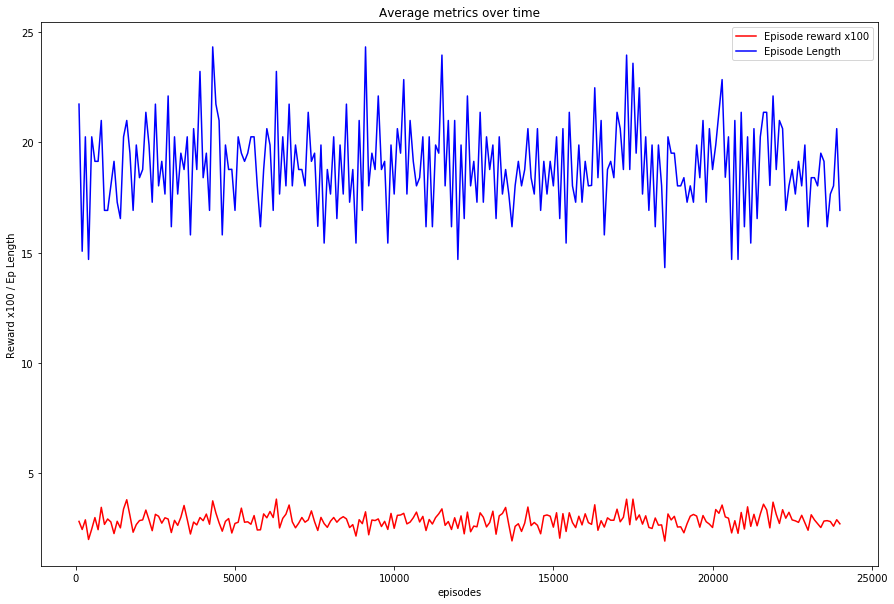

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

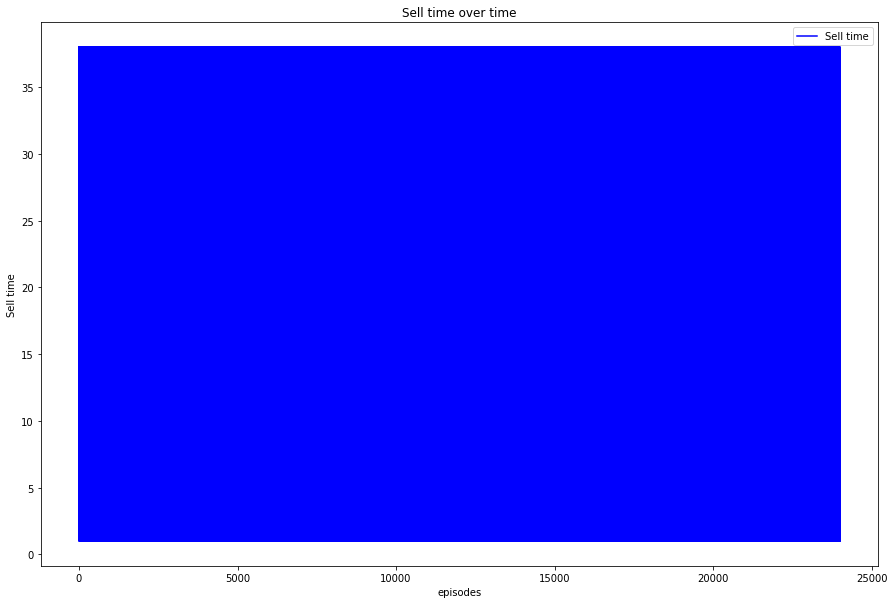

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 121.1553335570293, max value of stock: 180.06841858691385


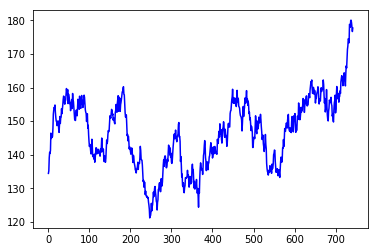

In [36]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [37]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version\savedModel\RL_10000rep_200seeds_0001_128batch_1000pre_arch0-option_T50-history_t15-dueling_typemax-freq300-batch128-capacity10000-lambda0.0001-final
episode 100: 	0.023585336333908802	16.54
episode 200: 	0.030589803067488316	20.24
episode 300: 	0.03079231517095652	18.76
episode 400: 	0.03391981948585577	20.24
episode 500: 	0.024821223797271433	18.02
episode 600: 	0.02435944967719502	18.76
episode 700: 	0.02636703379812437	19.13
episode 800: 	0.03217397284943595	22.46
episode 900: 	0.030962555724731607	21.72
episode 1000: 	0.02609610070790445	21.35
episode 1100: 	0.026221588605635025	19.13
episode 1200: 	0.021383899110896127	17.65
episode 1300: 	0.03384906891232343	18.39
episode 1400: 	0.03352400222743783	21.35
episode 1500: 	0.029694098070195473	19.5
episode 1600: 	0.023261956157646476	18.39
episode 1700: 	0.023216218367087555	19.13
episode 1800: 	0.024

episode 18600: 	0.029603094216845607	20.24
episode 18700: 	0.031617236621005504	22.09
episode 18800: 	0.02549058793779	18.39
episode 18900: 	0.028238327966827084	17.65
episode 19000: 	0.025204622190674902	18.02
episode 19100: 	0.03136955193672463	22.09
episode 19200: 	0.026743518760858283	18.39
episode 19300: 	0.0273234118418947	17.65
episode 19400: 	0.025260538571362793	18.76
episode 19500: 	0.028754943651589916	16.54
episode 19600: 	0.02775967915774351	17.65
episode 19700: 	0.036906325020107114	21.38
episode 19800: 	0.018669000624651644	18.76
episode 19900: 	0.035022744174223346	22.09
episode 20000: 	0.025907179200340035	17.65
#Average reward per episode 20000: 0.028275576030181965
episode 20100: 	0.02612505048617681	15.06
episode 20200: 	0.024742408748890474	19.13
episode 20300: 	0.033330874938130306	18.02
episode 20400: 	0.02707146079335444	16.17
episode 20500: 	0.03625081286763018	22.83
episode 20600: 	0.027036048035911812	18.02
episode 20700: 	0.028813431459282543	19.87
episode 2

episode 37500: 	0.026109165281775804	15.44
episode 37600: 	0.02917632203013752	19.13
episode 37700: 	0.02541815974292589	16.54
episode 37800: 	0.030673828733070074	20.24
episode 37900: 	0.02331412110358422	18.02
episode 38000: 	0.03373741426781696	21.72
episode 38100: 	0.023105367521808334	17.65
episode 38200: 	0.03475208878601887	22.83
episode 38300: 	0.027975384686260332	17.65
episode 38400: 	0.026745463923145394	18.02
episode 38500: 	0.032809086710213584	22.09
episode 38600: 	0.022785377024716856	17.28
episode 38700: 	0.024678278766559914	19.87
episode 38800: 	0.025326489863144327	18.02
episode 38900: 	0.030234337357396494	19.13
episode 39000: 	0.020706559545518203	15.43
episode 39100: 	0.02615506710653519	18.39
episode 39200: 	0.029495002298265172	18.39
episode 39300: 	0.032797163251613616	22.09
episode 39400: 	0.02289776665089561	16.54
episode 39500: 	0.03247284472331355	23.2
episode 39600: 	0.03357176195543896	23.2
episode 39700: 	0.034695846533653735	19.13
episode 39800: 	0.0236

episode 56300: 	0.02627365800952047	17.28
episode 56400: 	0.028272612591786768	17.28
episode 56500: 	0.02600919700065778	21.35
episode 56600: 	0.027939842788244747	19.5
episode 56700: 	0.02680224900517901	19.5
episode 56800: 	0.03005263180660096	19.87
episode 56900: 	0.03215071663750111	22.83
episode 57000: 	0.025450436526426735	16.91
episode 57100: 	0.03456696604850948	20.61
episode 57200: 	0.023274510378581418	17.28
episode 57300: 	0.032035494124875524	22.83
episode 57400: 	0.027087401678329938	19.5
episode 57500: 	0.03893044110719471	25.06
episode 57600: 	0.02585214251412856	16.91
episode 57700: 	0.02595799055334769	19.5
episode 57800: 	0.023516564922159467	18.39
episode 57900: 	0.029273870323813976	18.76
episode 58000: 	0.027563012319408012	16.54
episode 58100: 	0.030889369212081342	18.76
episode 58200: 	0.029146751704931972	19.87
episode 58300: 	0.02759975066456334	18.39
episode 58400: 	0.02080432130835832	17.28
episode 58500: 	0.04003241583310238	22.83
episode 58600: 	0.028008229

episode 75100: 	0.03123289012674192	20.61
episode 75200: 	0.027927265896198393	18.02
episode 75300: 	0.033835365817331146	20.61
episode 75400: 	0.033721984233044525	19.87
episode 75500: 	0.025152825983653426	18.39
episode 75600: 	0.031097559285481875	19.5
episode 75700: 	0.020367592443809555	16.54
episode 75800: 	0.028555429326345208	18.39
episode 75900: 	0.0299654574942323	19.51
episode 76000: 	0.019729545576446968	16.17
episode 76100: 	0.030052971049080463	20.24
episode 76200: 	0.02785402545236807	17.65
episode 76300: 	0.03537643211862536	20.61
episode 76400: 	0.01934621990107492	14.69
episode 76500: 	0.021946060623503412	18.02
episode 76600: 	0.032884494482495606	19.87
episode 76700: 	0.028272974031421597	20.98
episode 76800: 	0.029266041764715037	18.76
episode 76900: 	0.031853447034841144	20.98
episode 77000: 	0.0236039295747931	16.91
episode 77100: 	0.035594415933234355	22.09
episode 77200: 	0.029029941613732967	18.39
episode 77300: 	0.025605613169053097	16.91
episode 77400: 	0.03

episode 94000: 	0.02842767085267627	16.91
episode 94100: 	0.03058757077100484	17.28
episode 94200: 	0.027812705513686167	19.5
episode 94300: 	0.036463336417335554	19.5
episode 94400: 	0.02709017759350866	18.39
episode 94500: 	0.036133264941357185	22.09
episode 94600: 	0.030925462946470042	18.76
episode 94700: 	0.03399542707123245	20.61
episode 94800: 	0.02588221128110172	19.87
episode 94900: 	0.02813009578348807	20.61
episode 95000: 	0.020425609426304475	17.29
#Average reward per episode 95000: 0.028145150758043268
episode 95100: 	0.026704699609825782	19.5
episode 95200: 	0.01843101812155138	17.65
episode 95300: 	0.030359961615181143	19.5
episode 95400: 	0.024933533357005835	18.39
episode 95500: 	0.030363913415993787	18.02
episode 95600: 	0.029876030690863576	16.91
episode 95700: 	0.025056080046306443	19.87
episode 95800: 	0.03149831114246391	23.2
episode 95900: 	0.021100732385222507	18.39
episode 96000: 	0.02253057197593781	16.91
episode 96100: 	0.0270085988663611	18.02
episode 96200:

episode 112500: 	0.033141623490871804	20.24
episode 112600: 	0.02435453942601122	20.61
episode 112700: 	0.03135871206597426	22.09
episode 112800: 	0.03416960010396558	20.24
episode 112900: 	0.02788762592443271	20.61
episode 113000: 	0.028284958915464273	16.92
episode 113100: 	0.02395345557657028	17.28
episode 113200: 	0.024616828086784635	16.17
episode 113300: 	0.024591176861593334	16.54
episode 113400: 	0.02407538043552702	16.91
episode 113500: 	0.03259835688747041	17.65
episode 113600: 	0.026351818781683176	18.39
episode 113700: 	0.0311970421980415	20.24
episode 113800: 	0.026599011084065864	18.39
episode 113900: 	0.0312992442247093	20.61
episode 114000: 	0.025832244652559545	19.5
episode 114100: 	0.029886340657956992	19.5
episode 114200: 	0.027478415272317442	18.39
episode 114300: 	0.03956403102939793	22.83
episode 114400: 	0.025479797683609622	18.02
episode 114500: 	0.021951510555200344	18.76
episode 114600: 	0.028210705281572192	20.98
episode 114700: 	0.03535429800620288	20.98
epi

episode 130900: 	0.022164065645345867	16.54
episode 131000: 	0.023379958570235438	16.17
episode 131100: 	0.031047700542498124	22.09
episode 131200: 	0.025549041749389986	18.02
episode 131300: 	0.03506662232041175	22.46
episode 131400: 	0.028299755038406725	17.28
episode 131500: 	0.029837657958262855	17.28
episode 131600: 	0.02026469282978034	17.28
episode 131700: 	0.025469356630467822	17.65
episode 131800: 	0.023494248065511883	16.91
episode 131900: 	0.03284852890766663	21.35
episode 132000: 	0.037698872508981615	21.35
episode 132100: 	0.022108062395027953	16.91
episode 132200: 	0.038651654757431375	19.5
episode 132300: 	0.028228063973609854	20.61
episode 132400: 	0.030071211466372882	19.87
episode 132500: 	0.02467270467361565	16.17
episode 132600: 	0.03409021259399358	20.24
episode 132700: 	0.029877102081771755	19.13
episode 132800: 	0.021269886590911894	17.28
episode 132900: 	0.028092692798366906	20.98
episode 133000: 	0.026833046813963802	16.17
episode 133100: 	0.03190037855529822	1

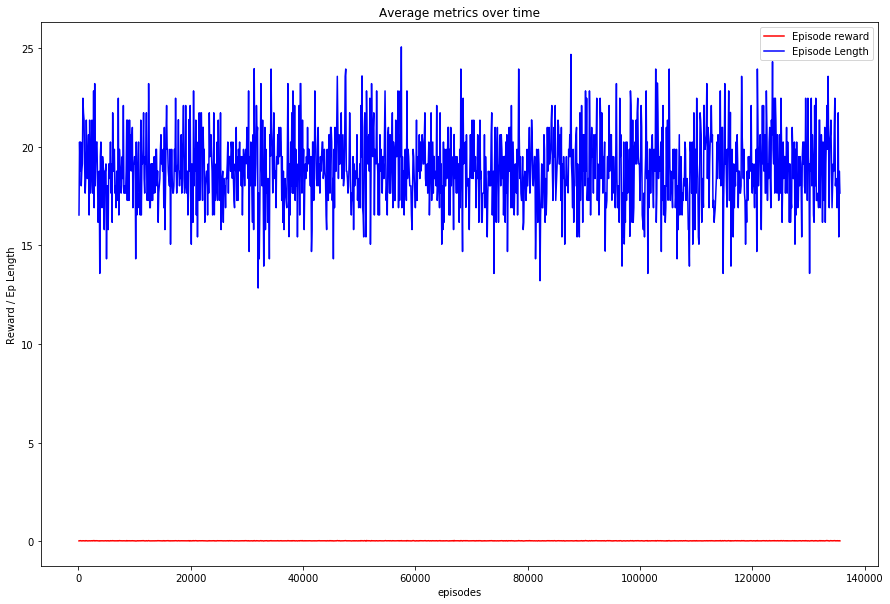

In [39]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

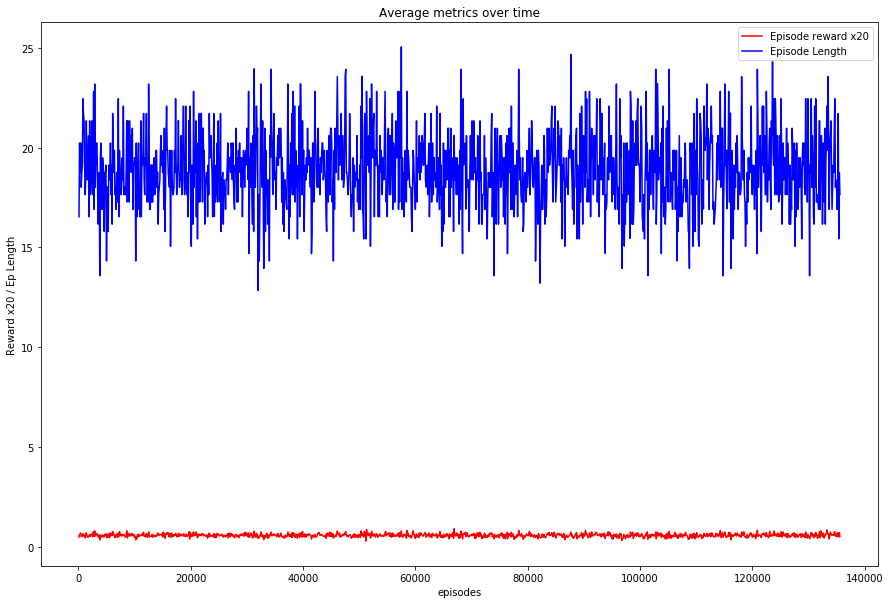

In [40]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

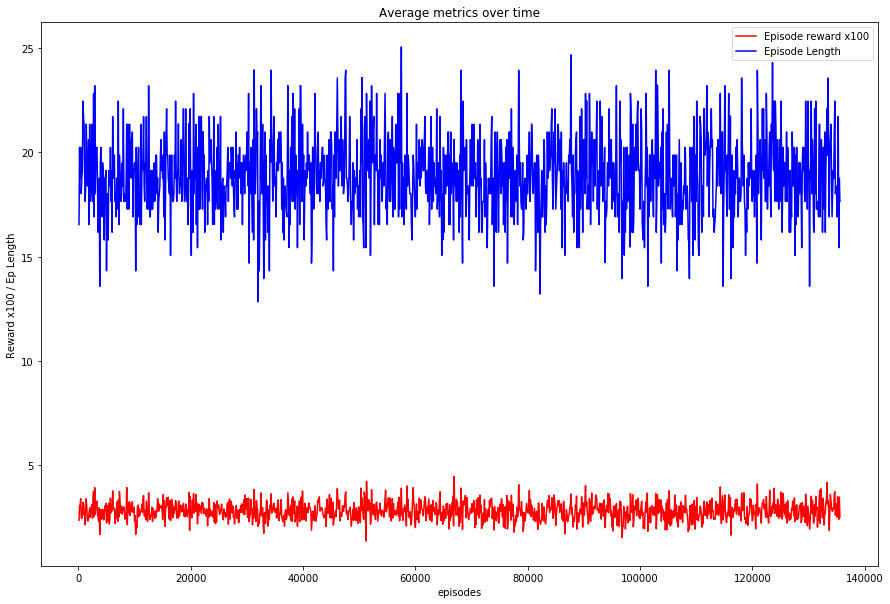

In [41]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

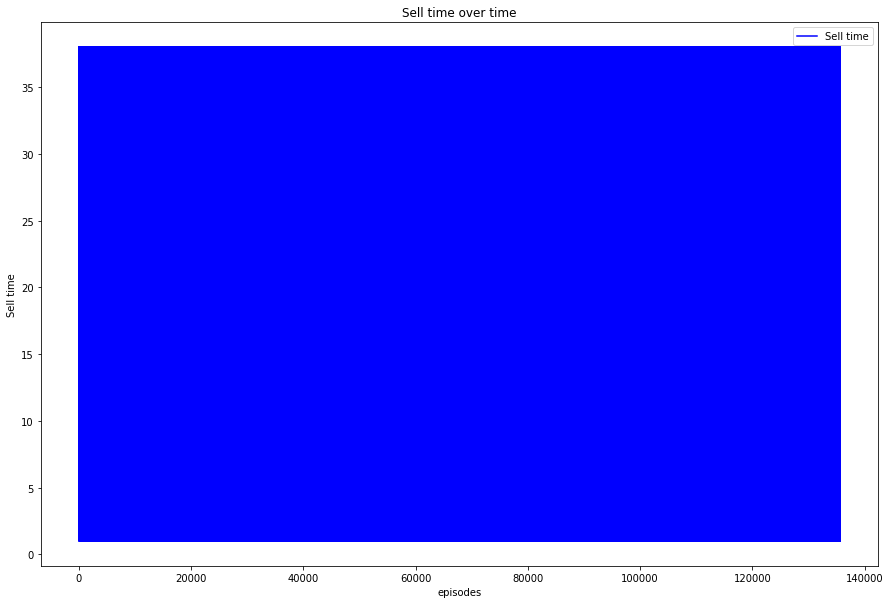

In [42]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [43]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 1174048
maxPossibleOptionP_returnList: 1174048
maxPossibleOptionR_P_returnList: 1174048
maxPossibleP_returnList: 1174048
maxPossibleR_P_returnList: 1174048
maxPossiblerList: 1174048
option_percentage_rList: 1174048
option_real_percentage_rList: 1174048
percentage_rList: 1174048
rList: 1174048
real_percentage_rList: 1174048
sTimeList: 1174048
AvgEpisodeList: 11520
AvgrList: 11520
AvgsTimeList: 11520
stock_data: 7984
real_train_data: 6040
train_data: 6040
Qnetwork: 2000
real_stocks_test_data: 1672
real_stocks_train_data: 1672
stocks_data: 1672
stocks_test_data: 1672
stocks_train_data: 1672
real_test_data: 1576
test_data: 1576
AmericanOptionPricing: 1056
GBM: 1056
MinMaxScaler: 1056
experience_buffer: 1056
episodeBuffer: 528
path: 309
final_trained_model_name: 273
trained_model_name: 267
s1P: 232
sP: 232
build_data: 136
leaky_relu: 136
length: 136
normalize_data: 136
prepare_company_stock: 136
prepare_data: 136
processState: 136
set_seed: 136
updateTarget: 136
updateTargetGraph: 13